In [4]:
 #pip install gurobipy

In [5]:
# Import packages
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import json



# Data Inputs (& flexibility param)


In [6]:
# Run this once to open JSONs (all files from /task1/data)

import json
import csv
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# load JSONs
with open('./data/question_1a/bus_params.json', 'r') as file:
    bus_params = json.load(file)
#print(json.dumps(bus_params, indent=4))
with open('./data/question_1a/DER_production.json', 'r') as file:
    der_production = json.load(file)
#print(json.dumps(der_production, indent=4))

with open('./data/question_1a/appliance_params.json', 'r') as file:
    appl_params= json.load(file)
#print(json.dumps(appl_params, indent=4))

with open('./data/question_1a/usage_preference.json', 'r') as file:
    usage_preference= json.load(file)
#print(json.dumps(usage_preference, indent=4))


# Read relevant fields from JSONs

# Lmin_t : minimum hourly flexible load (kWh/h). Lmint = 0 here because the load is fully flexible.
Lmin_t = 0.0
# Lmax_t : maximum hourly flexible load (kWh/h).
Lmax_t = appl_params["load"][0]["max_load_kWh_per_hour"]
# Pt_PV : Hourly available PV production (kWh/h).
Pt_PV = der_production[0]["hourly_profile_ratio"] # TODO not sure if this is the correct array but the only one i could find aside from cost
# ct_PV : marginal PV production cost (DKK/kWh).
ct_PV = 1 #  TODO could not find PV production cost  in JSON
# pt: electricity price (DKK/kWh).
pt = bus_params[0]["energy_price_DKK_per_kWh"]
# tau_t ≥ 0: Hourly profiles of non-negative distribution grid tariff (DKK/kWh).
tau_t = 0 # TODO value is null in json, modify model to not use it?
#Emin: minimum daily required energy consumption (kWh) ,  expressed as # of hours equivalent at maximum capacity
Emin_hour_equivalent = usage_preference[0]["load_preferences"][0]["min_total_energy_per_day_hour_equivalent"] #TODO does our model use 'hour equivalent?'
Emin = Emin_hour_equivalent * Lmax_t

# print to test
print(str(len(pt)) + ' x energy prices are : ' + str(pt) )
print(str(len(Pt_PV)) + ' x energy produced are : ' + str(Pt_PV) )
print("max load : " + str(Lmax_t))
print("min load : " + str(Lmin_t))
print("min energy consumption: " + str(Emin))


# these seem relevant but our model doesnt use them :o
import_tariff = bus_params[0]["import_tariff_DKK/kWh"]
export_tariff = bus_params[0]["export_tariff_DKK/kWh"]
max_import_kW = bus_params[0]["max_import_kW"]
max_export_kW = bus_params[0]["max_export_kW"]
penalty_excess_import = bus_params[0]["penalty_excess_import_DKK/kWh"]
penalty_excess_export = bus_params[0]["penalty_excess_export_DKK/kWh"]

FileNotFoundError: [Errno 2] No such file or directory: './data/question_1a/bus_params.json'

## Descision Variables


In [ ]:

# Make model
model = gp.Model("Task1")
HOURS = list(range(24))


## deafult upper bound and lower bound of each variable
## TODO are bounds correct?
lb = 0.0
ub = float('inf')


#one var:
#Lt = model.addVar(lb, ub=float('inf'), vtype=GRB.CONTINUOUS, name="Lt")


# one var for every t:
# Lt: load consumption (kWh).
Lt = {t: model.addVar(Lmin_t, Lmax_t,vtype=GRB.CONTINUOUS, name='L{0}'.format(t)) for t in HOURS}

# st: PV self-consumed (kWh).
st= {t: model.addVar(lb, ub, vtype=GRB.CONTINUOUS, name='s{0}'.format(t)) for t in HOURS}

# TODO i think we misunderstood this variable, this is the amount the PV uses to function? while we are using it to represent how much of the PV's envery is going to the load/household. i think we just named it wrong, as we dont know how much the pv consumes

# ct: PV curtailed (kWh).
ct = {t: model.addVar(lb, ub,vtype=GRB.CONTINUOUS, name='c{0}'.format(t)) for t in HOURS}

# gt_imp : grid import (kWh).
gt_imp = {t: model.addVar(lb, max_import_kW, vtype=GRB.CONTINUOUS, name='g{0}_imp'.format(t)) for t in HOURS}

# gt_exp : grid export (kWh).
gt_exp = {t: model.addVar(lb, max_export_kW,vtype=GRB.CONTINUOUS, name='g{0}_exp'.format(t)) for t in HOURS}


model.update()
vars = model.getVars()
print("added " + str(len(vars)) + " variables")


Restricted license - for non-production use only - expires 2026-11-23
added 120 variables


# Constraints

In [ ]:
# (Load bounds) 0 ≤ Lt ≤ Lmaxt ,
# This has been implemented in variable definitinon, where upper and lower bound of variable have been set to Lmax_t and Lmin_t

# (Daily minimum consumption) SUM(Lt) ≥ Emin,
constraints = [
        (
                model.addLConstr(
                        gp.quicksum(Lt[t] for t in HOURS),
                        GRB.GREATER_EQUAL,
                        Emin,
                        name="Daily_minimum"
                )
        )
]


# (PV allocation) Lt + st + ct + gt_exp = Pt_PV
# &
# (Energy balance at consumer node) st + gt_imp = Lt + gt_exp
for t in HOURS :
    model.addLConstr(st[t] + ct[t], GRB.EQUAL , Pt_PV[t], name='PV_allocation')
    model.addLConstr(st[t] + gt_imp[t], GRB.EQUAL , Lt[t], name='Load_allocation')
    model.addLConstr(st[t] + gt_imp[t], GRB.EQUAL , Lt[t] + gt_exp[t] + ct[t], name='Engergy_balance_at_node')

## can also be written as
#pv_alloc = {t: model.addLConstr(st[t] + ct[t] + gt_exp[t], GRB.EQUAL , Pt_PV[t], name='PV_allocation') for t in HOURS }


model.update()
print(str(model.getConstrs))

<bound method Model.getConstrs of <gurobi.Model Continuous instance Task1: 73 constrs, 120 vars, No parameter changes>>


# Objective

In [ ]:
# TODO changed objective function, removed "+ gexp" from last term bc we shouldnt multiply grid export with pv-production cost? (update latex model?)
model.setObjective(
    gp.quicksum(
        (pt[t] + tau_t) * gt_imp[t] - (pt[t] + tau_t) * gt_exp[t]  + ct_PV*Pt_PV[t]
        for t in HOURS
    ), GRB.MINIMIZE)

In [ ]:
# Optimize the model
model.optimize()

# Check the optimization status
if model.status == GRB.OPTIMAL:
    print("Optimization successful!")
    # You can access the optimal objective value and variable values here
    print("Optimal objective value:", model.ObjVal)
    for v in model.getVars():
        if v.X > 1e-6: # Print only variables with non-zero values
            print(v.VarName, v.X)
elif model.status == GRB.INFEASIBLE:
    print("Model is infeasible")
elif model.status == GRB.UNBOUNDED:
    print("Model is unbounded")
else:
    print("Optimization ended with status", model.status)

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 73 rows, 120 columns and 264 nonzeros
Model fingerprint: 0xbece757a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 2e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [5e-02, 2e+01]
Presolve removed 42 rows and 51 columns
Presolve time: 0.01s
Presolved: 31 rows, 69 columns, 129 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1613678e+01   5.102224e+01   0.000000e+00      0s
      38    2.3171500e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.317150000e+01
Optimization successful!
Optimal objective value: 23.1715
L1 0.29000000000000015
L2 3.0
L3 3.0
L4 3.0
L5 3.0
L6 0.14
L7 0

# Visualization


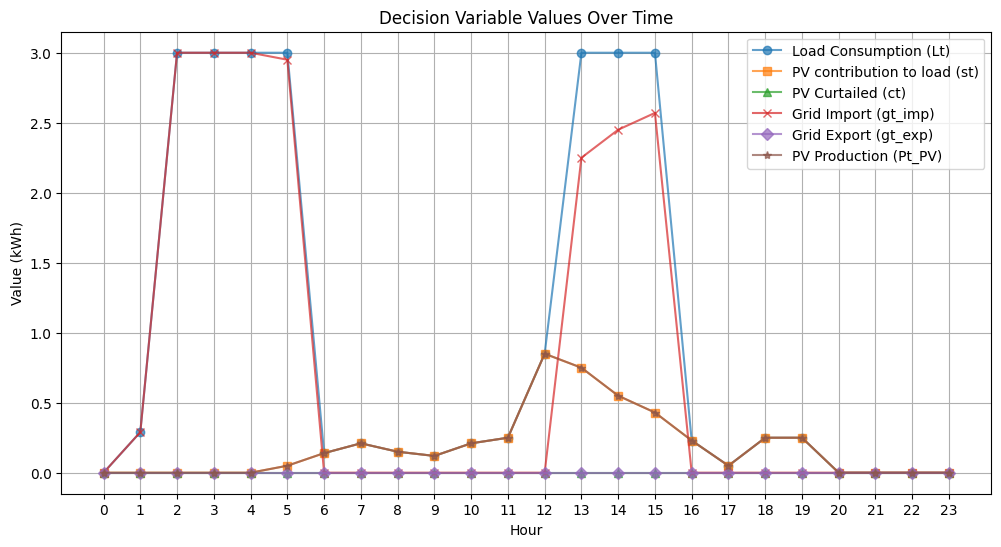

In [ ]:
import matplotlib.pyplot as plt

# Extract variable values from the optimization results
Lt_values = [Lt[t].X for t in HOURS]
st_values = [st[t].X for t in HOURS]
ct_values = [ct[t].X for t in HOURS]
gt_imp_values = [gt_imp[t].X for t in HOURS]
gt_exp_values = [gt_exp[t].X for t in HOURS]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(HOURS, Lt_values, label='Load Consumption (Lt)', alpha=0.7, marker='o')
plt.plot(HOURS, st_values, label='PV contribution to load (st)', alpha=0.7, marker='s')
plt.plot(HOURS, ct_values, label='PV Curtailed (ct)', alpha=0.7, marker='^')
plt.plot(HOURS, gt_imp_values, label='Grid Import (gt_imp)', alpha=0.7, marker='x')
plt.plot(HOURS, gt_exp_values, label='Grid Export (gt_exp)', alpha=0.7, marker='D')
Pt_PV = der_production[0]["hourly_profile_ratio"]
plt.plot(HOURS, Pt_PV, label='PV Production (Pt_PV)', alpha=0.7, marker='*')

# Add labels and title
plt.xlabel('Hour')
plt.ylabel('Value (kWh)')
plt.title('Decision Variable Values Over Time')
plt.xticks(HOURS)
plt.legend()
plt.grid(True)
plt.show()

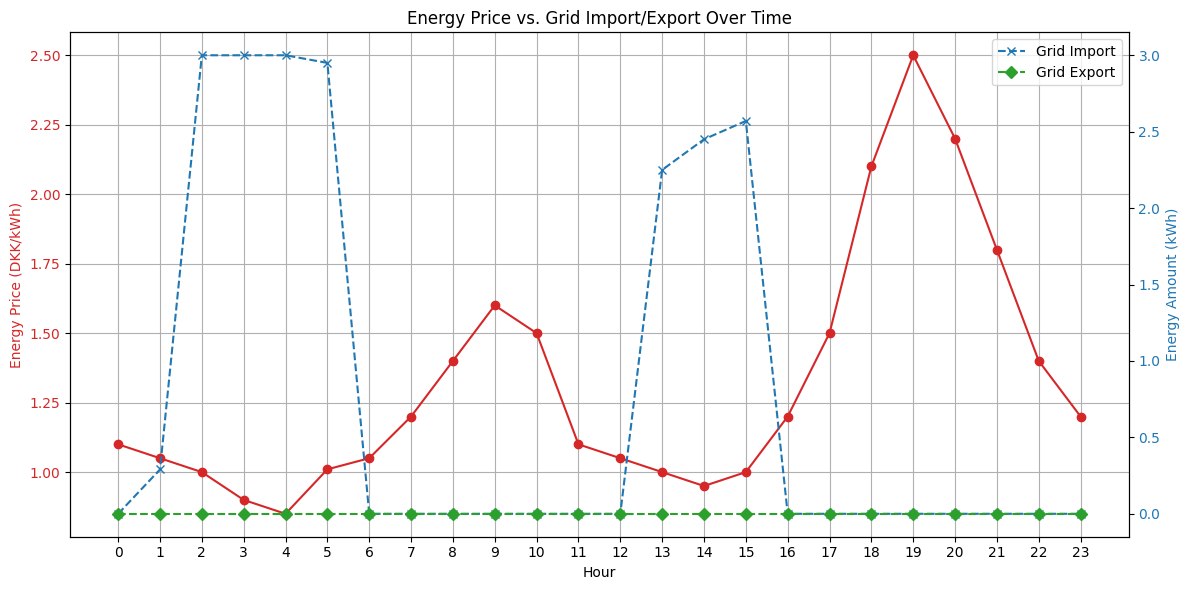

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot energy price on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Hour')
ax1.set_ylabel('Energy Price (DKK/kWh)', color=color)
ax1.plot(HOURS, pt, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Create a second y-axis for import/export
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Energy Amount (kWh)', color=color)
ax2.plot(HOURS, gt_imp_values, color='tab:blue', marker='x', linestyle='dashed', label='Grid Import')
ax2.plot(HOURS, gt_exp_values, color='tab:green', marker='D', linestyle='dashed', label='Grid Export')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and legend
plt.title('Energy Price vs. Grid Import/Export Over Time')
fig.tight_layout() # To prevent labels overlapping
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.xticks(HOURS)
plt.show()

# With Classes


In [ ]:
class Expando(object):
    '''
        A small class which can have attributes set
    '''
    pass

In [ ]:
class InputData:

    def __init__(
        self,
        VARIABLES: list,
        objective_coeff: list[str, int],    # Coefficients in objective function
        constraints_coeff: list[str, int],  # Linear coefficients of constraints
        constraints_rhs: list[str, int],    # Right hand side coefficients of constraints
        constraints_sense: list[str, int],  # Direction of constraints
    ):
        self.VARIABLES = VARIABLES
        self.objective_coeff = objective_coeff
        self.constraints_coeff = constraints_coeff
        self.constraints_rhs = constraints_rhs
        self.constraints_sense = constraints_sense

In [ ]:
class LP_OptimizationProblem():

    def __init__(self, input_data: InputData): # initialize class
        self.data = input_data # define data attributes
        self.results = Expando() # define results attributes
        self._build_model() # build gurobi model

    def _build_variables(self):
        self.variables = {v: self.model.addVar(lb=0, name='Total production of CHP {0}'.format(v)) for v in self.data.VARIABLES}

    def _build_constraints(self):
        self.constraints = [
            (
                self.model.addLConstr(
                        gp.quicksum(self.data.constraints_coeff[v][i] * self.variables[v] for v in self.data.VARIABLES),
                        self.data.constraints_sense[i],
                        self.data.constraints_rhs[i]
                )
            ) for i in range(len(self.data.constraints_rhs))
        ]

    def _build_objective_function(self):
        objective = gp.quicksum(self.data.objective_coeff[v] * self.variables[v] for v in self.data.VARIABLES)
        self.model.setObjective(objective, GRB.MINIMIZE)

    def _build_model(self):
        self.model = gp.Model(name='Economic dispatch')
        self._build_variables()
        self._build_objective_function()
        self._build_constraints()
        self.model.update()

    def _save_results(self):
        self.results.objective_value = self.model.ObjVal
        self.results.variables = {v: self.variables[v].x for v in self.data.VARIABLES}
        self.results.duals = [self.constraints[i].Pi for i in range(len(self.constraints))]

    def run(self):
        self.model.optimize()
        if self.model.status == GRB.OPTIMAL:
            self._save_results()
        else:
            print(f"optimization of {model.ModelName} was not successful")

    def display_results(self):
        print()
        print("-------------------   RESULTS  -------------------")
        print("Optimal objective value:")
        print(self.results.objective_value)
        print("Optimal variable values:")
        print(self.results.variables)
        print("Optimal dual values:")
        print(self.results.duals)

In [ ]:
# This corresponds to the main function
input_data = InputData(
    VARIABLES = ['x1', 'x2'],
    objective_coeff = {'x1': 30, 'x2': 20},
    constraints_coeff = {'x1': [0.6, 0.4], 'x2': [0.2, 0.8]},
    constraints_rhs = [60, 100],
    constraints_sense =  [GRB.GREATER_EQUAL, GRB.GREATER_EQUAL],
)
problem = LP_OptimizationProblem(input_data)
problem.run()
problem.display_results()